In [8]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

위험 균형(Risk Parity) 전략을 목표 변동성(Target Volatility)을 맞추어 같이 사용할 수도 있습니다. 이럴 경우, 변동성이 매우 낮은 시장 상황이면 레버리지를 사용해 목표 변동성을 맞출 것이고, 변동성이 크다면 비중을 1보다 낮게 가져가 현금을 보유하도록 할 수 있습니다. 여기서는 포트폴리오 목표 변동성을 10%로 하고, 9.5% ~ 10.5% 사이에 들어오도록 맞추어 보겠습니다. 데이터는 시간이 오래 걸릴 수 있으니 미국 주식, 미국 장기 국채, 미국 물가채, 미국 단기 국채, 금, 원자재 데이터를 사용합니다. 미국 단기 국채는 현금 대용입니다. 가장 최근에 생긴 GSG ETF의 시작점부터 테스트합니다. 함수에는 자산 최대 보유 비중과 최소 보유 비중을 입력하도록 구현합니다.

In [9]:
start = '2006-07-21'
end = '2021-05-07'

vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("tlt")
tip = web.DataReader("TIP", 'yahoo', start, end)['Adj Close'].to_frame("tip")
iau = web.DataReader("IAU", 'yahoo', start, end)['Adj Close'].to_frame("iau")
gsg = web.DataReader("GSG", 'yahoo', start, end)['Adj Close'].to_frame("gsg")
shy = web.DataReader("SHY", 'yahoo', start, end)['Adj Close'].to_frame("shy")

가격 데이터로 수익률 데이터를 만듭니다.

In [10]:
price_df = pd.concat([vti, tlt, tip, iau, gsg], axis=1)
return_df = price_df.pct_change().dropna(axis=0)

cash_return_df = shy.pct_change().dropna(axis=0)

In [11]:
return_df.head()

,vti,tlt,tip,iau,gsg
Date,,,,,
2006-07-24,0.019468,-0.000586,-0.000802,-0.012449,0.009137
2006-07-25,0.003370,-0.002932,0.001906,0.009987,-0.009054
2006-07-26,0.002719,0.003646,0.003304,0.005025,0.007513
2006-07-27,-0.002552,-0.001523,0.000200,0.015484,0.010681
2006-07-28,0.008795,0.005751,0.002992,0.003018,-0.011964


In [12]:
cash_return_df.head()

,shy
Date,
2006-07-21,-0.000251
2006-07-24,0.000000
2006-07-25,-0.000250
2006-07-26,0.001255
2006-07-27,0.000501


In [13]:
def RiskParityTargetVol(rets, target, lb, ub) :

    covmat = pd.DataFrame.cov(rets)

    # 목적함수
    def RiskParityObjective(x) :
            
            variance = x.T @ covmat @ x
            sigma = variance ** 0.5
            mrc = 1/sigma * (covmat @ x)
            rc = x * mrc
            a = np.reshape(rc.to_numpy(), (len(rc), 1))
            # 각 자산의 위험 기여도가 같도록
            # 아래쪽의 목적함수가 위험 기여도 차이의 제곱의 합이니 그것이 0에 가깝게 가야 함
            risk_diffs = a - a.T
            # np.ravel: 다차원 배열 -> 1차원 배열
            # 1차원으로 풀어준 후에 제곱 -> 합 -> 목적함수
            sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
            return (sum_risk_diffs_squared)
    
    # 제약조건: 연간 변동성이 target vol의 95% 이상일 것
    def TargetVolLowerBound(x) :
        
        variance = x.T @ covmat @ x
        sigma = variance ** 0.5 
        sigma_scale = sigma * np.sqrt(252) 
        
        vol_diffs = sigma_scale - (target * 0.95)
        return(vol_diffs)  

    # 제약조건: 연간 변동성이 target vol의 105% 이하일 것
    def TargetVolUpperBound(x) :
        
        variance = x.T @ covmat @ x
        sigma = variance ** 0.5 
        sigma_scale = sigma * np.sqrt(252) 
        
        vol_diffs = (target * 1.05) - sigma_scale
        return(vol_diffs)      
    
    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1]) 
    lbound  = np.repeat(lb, covmat.shape[1])
    ubound  = np.repeat(ub, covmat.shape[1])
    bnds = tuple(zip(lbound, ubound))
    constraints = ({'type': 'ineq', 'fun': TargetVolLowerBound},
                   {'type': 'ineq', 'fun': TargetVolUpperBound})
    options = {'ftol': 1e-20, 'maxiter': 2000}
    
    result = minimize(fun = RiskParityObjective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    return(result.x)

위 함수는 목표 변동성 없이 구하는 위험 균형 함수와 비슷합니다. 그러나, 비중 합이 1이고 각 자산 비중이 0 이상이라는 제약 조건이 없으므로, 레버리지도 사용 가능합니다. 레버리지 사용 시 1을 초과하는 비중은 현금을 공매도한 것처럼 구현할 것입니다. 비중 합이 1보다 작은 경우 현금 보유를 해야 합니다. 편의상 현금 차입 비용은 미국 단기 국채 수익률로 대체할 것입니다.

자산 비중을 구하기 위한 rolling period는 자유롭게 변경 가능하지만, 편의상 62거래일(3개월)로 가정해 보겠습니다. 

In [14]:
# 62 days(3 months) 기준으로 rolling 
weight_df = pd.DataFrame(columns=['vti','tlt','tip','iau','gsg'])

for i in range(len(return_df)-62):
    
    print(i)
    
    # 63일 분량 데이터 잘라오기 (for문 돌 때마다 index 0~62, 1~63, 2~64, ...)
    temp_return_df = return_df.iloc[i:(i+63), :]
    
    # 63일 중 62일치를 계산에 사용하고 63번째 행은 날짜를 추출
    date_index = str(temp_return_df.iloc[62, :].name)[0:10]
    # Target vol 10% (0.1), 최소/최대 보유 비중은 0과 10 (Long Only, 10배 레버리지까지 허용)
    temp = pd.DataFrame(RiskParityTargetVol(temp_return_df.iloc[0:62, :], 0.1, 0, 10), index=['vti','tlt','tip','iau','gsg'], columns=[date_index]).T
    
    weight_df = pd.concat([weight_df, temp])

weight_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661


,vti,tlt,tip,iau,gsg
2006-10-19,0.459289,0.492520,0.717422,0.159827,0.157035
2006-10-20,0.498360,0.489454,0.711399,0.153790,0.159656
2006-10-23,0.496888,0.484726,0.714688,0.152074,0.158535
2006-10-24,0.506504,0.480282,0.718729,0.149554,0.160160
2006-10-25,0.502535,0.481113,0.713273,0.149470,0.158289
...,...,...,...,...,...
2021-05-03,0.202695,0.212571,0.429356,0.199731,0.155444
2021-05-04,0.203490,0.212366,0.426481,0.195621,0.155198
2021-05-05,0.204271,0.212170,0.425645,0.196330,0.154344
2021-05-06,0.203046,0.212227,0.421874,0.198211,0.154227


In [15]:
weight_df_final = weight_df

자산군 비중을 다 구했고, 현금 비중을 계산합니다. 현금은 각 자산군 비중 합계가 1보다 클 경우 레버리지를 구현하기 위해 차입한 것처럼 될 것이고, 비중 합계가 1보다 작을 경우 비중 총합을 1로 만들기 위하여 들어갈 것입니다.

In [16]:
weight_df_final['shy'] = 1 - weight_df_final.sum(axis = 1)
weight_df_final

,vti,tlt,tip,iau,gsg,shy
2006-10-19,0.459289,0.492520,0.717422,0.159827,0.157035,-0.986093
2006-10-20,0.498360,0.489454,0.711399,0.153790,0.159656,-1.012660
2006-10-23,0.496888,0.484726,0.714688,0.152074,0.158535,-1.006911
2006-10-24,0.506504,0.480282,0.718729,0.149554,0.160160,-1.015230
2006-10-25,0.502535,0.481113,0.713273,0.149470,0.158289,-1.004680
...,...,...,...,...,...,...
2021-05-03,0.202695,0.212571,0.429356,0.199731,0.155444,-0.199797
2021-05-04,0.203490,0.212366,0.426481,0.195621,0.155198,-0.193156
2021-05-05,0.204271,0.212170,0.425645,0.196330,0.154344,-0.192761
2021-05-06,0.203046,0.212227,0.421874,0.198211,0.154227,-0.189585


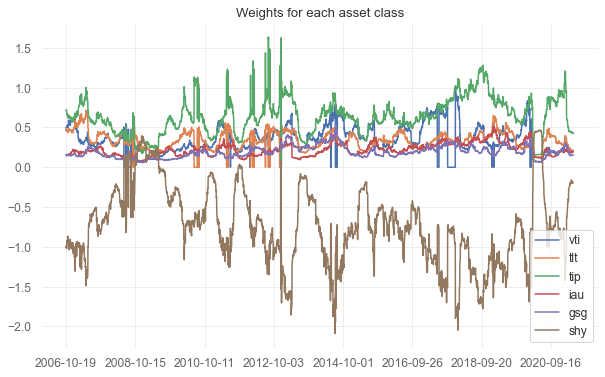

In [17]:
weight_df_final.plot(title = 'Weights for each asset class')

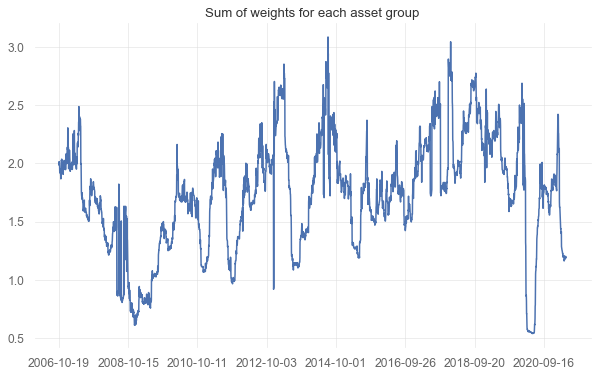

In [18]:
sum_of_asset_weight = 1 - weight_df_final['shy']
sum_of_asset_weight.plot(title = 'Sum of weights for each asset group')

시장 충격이 있어서 변동성이 큰 시기에 시장 노출을 줄이고, 현금 비중을 크게 가져가는 것을 볼 수 있습니다.

각 자산군의 가중치에 일간 수익률을 곱하고, 합산해서 risk parity with target volatility 전략의 모델 포트폴리오 수익률을 구합니다.

In [19]:
rp_tvol_return = (weight_df_final['vti'] * return_df.iloc[62:, :]['vti'] +
                  weight_df_final['tlt'] * return_df.iloc[62:, :]['tlt'] + 
                  weight_df_final['tip'] * return_df.iloc[62:, :]['tip'] +
                  weight_df_final['iau'] * return_df.iloc[62:, :]['iau'] +
                  weight_df_final['gsg'] * return_df.iloc[62:, :]['gsg'] + 
                  weight_df_final['shy'] * cash_return_df.iloc[62:, :]['shy'])
        
rp_tvol_return

2006-10-18         NaN
2006-10-19    0.004487
2006-10-20   -0.004732
2006-10-23   -0.005457
2006-10-24    0.005487
                ...   
2021-05-03    0.005104
2021-05-04    0.001649
2021-05-05    0.003304
2021-05-06    0.004849
2021-05-07    0.003809
Length: 3663, dtype: float64

In [20]:
rp_tvol_return.index

DatetimeIndex(['2006-10-18', '2006-10-19', '2006-10-20', '2006-10-23',
               '2006-10-24', '2006-10-25', '2006-10-26', '2006-10-27',
               '2006-10-30', '2006-10-31',
               ...
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07'],
              dtype='datetime64[ns]', length=3663, freq=None)

인덱스가 DatetimeIndex 형식이 아니므로 DatetimeIndex 형식으로 변환합니다.

In [21]:
rp_tvol_return.index = pd.to_datetime(rp_tvol_return.index)

In [22]:
rp_tvol_return.index

DatetimeIndex(['2006-10-18', '2006-10-19', '2006-10-20', '2006-10-23',
               '2006-10-24', '2006-10-25', '2006-10-26', '2006-10-27',
               '2006-10-30', '2006-10-31',
               ...
               '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07'],
              dtype='datetime64[ns]', length=3663, freq=None)

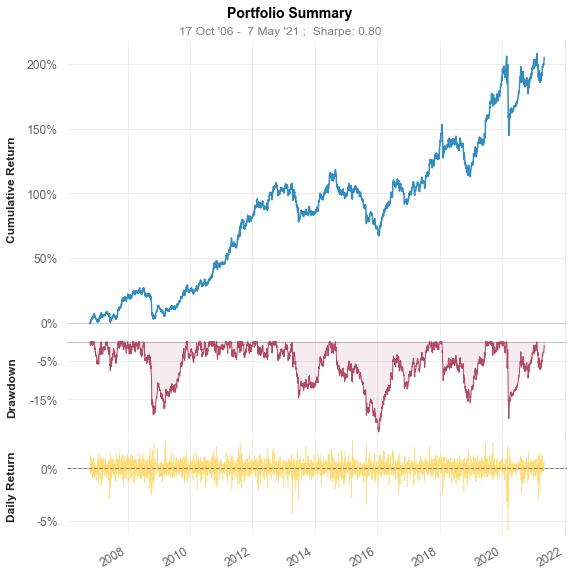

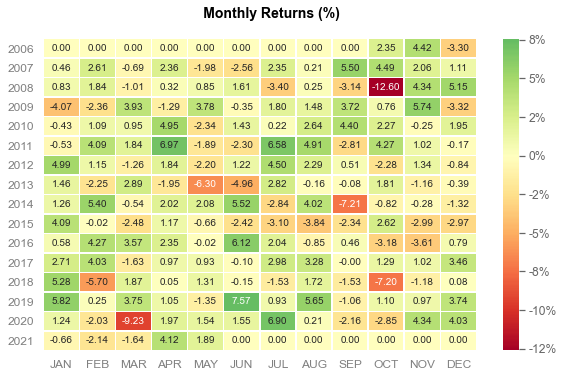

In [23]:
quantstats.reports.plots(rp_tvol_return, mode='basic')

아래 값들은 이 전략의 성과입니다. 구현 목표였던 연간 변동성 10%에 근접하게 나오고 있습니다.

In [24]:
quantstats.reports.metrics(rp_tvol_return, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2006-10-18
End Period                 2021-05-07
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          204.92%
CAGR%                      7.96%
Sharpe                     0.8
Sortino                    1.11
Max Drawdown               -23.47%
Longest DD Days            1094
Volatility (ann.)          10.29%
Calmar                     0.34
Skew                       -0.67
Kurtosis                   4.42

Expected Daily %           0.03%
Expected Monthly %         0.64%
Expected Yearly %          7.22%
Kelly Criterion            6.79%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.03%
Expected Shortfall (cVaR)  -1.03%

Payoff Ratio               0.98
Profit Factor              1.14
Common Sense Ratio         1.16
CPC Index                  0.6
Tail Ratio                 1.01
Outlier Win Ratio          3.15
Outlier Loss Ratio         3.

In [25]:
quantstats.reports.html(rp_tvol_return, output='Report_RPTVOL.html', title='Risk Parity with 10% Target Vol')